# Analysis of the effect of $SO_2$ on quantification of $SO_2^{\text{Unmixed}}$

## Initial processing of the experimental results

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from pymcx import read_output_file, load_mcx_settings
from spectra import blood_mu_a, melanosome_mu_a, water_mu_a

matplotlib.rcParams['figure.figsize'] = (4,4)
matplotlib.rcParams.update({'font.size': 18})

Load the list of parameters run and the files containing the output and settings files. The constant variables are removed for the summary tables.

In [2]:
parameters = pd.read_csv("params.csv", index_col=0)
# Simulations were run for a couple of different melanin concentrations.
parameters = parameters[parameters["Melanin"]==0.01]
parameters.loc[:, parameters.nunique()>1]

,SO2,Wavelength,OutputFile,SettingsFile
21,0.0,7.000000e-07,result_0_01_00.mc2,settings_0_01_00.json
22,0.0,7.100000e-07,result_0_01_01.mc2,settings_0_01_01.json
23,0.0,7.200000e-07,result_0_01_02.mc2,settings_0_01_02.json
24,0.0,7.300000e-07,result_0_01_03.mc2,settings_0_01_03.json
25,0.0,7.400000e-07,result_0_01_04.mc2,settings_0_01_04.json
...,...,...,...,...
247,1.0,8.600000e-07,result_0_11_16.mc2,settings_0_11_16.json
248,1.0,8.700000e-07,result_0_11_17.mc2,settings_0_11_17.json
249,1.0,8.800000e-07,result_0_11_18.mc2,settings_0_11_18.json
250,1.0,8.900000e-07,result_0_11_19.mc2,settings_0_11_19.json


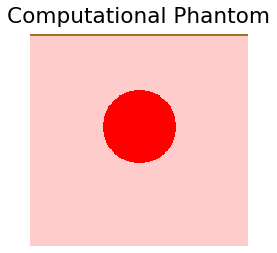

In [3]:
# View the phantom
settings = parameters["SettingsFile"].iloc[0]
volfile = parameters["VolumeFile"].iloc[0]

# Load the phantom settings.
mcx_settings = load_mcx_settings(settings)
dimension = tuple(mcx_settings["Domain"]["Dim"])
volume = np.fromfile(volfile, dtype="uint8").reshape(dimension + (-1,), order="F")

# Visualise the computational phantom.
cmap = matplotlib.colors.ListedColormap([(1,1,1), (163/255, 113/255, 38/255), (1, 0.8, 0.8), (1,0,0)])
plt.imshow(volume[:, 100, :, 0].T, cmap=cmap)
plt.title("Computational Phantom")
plt.axis("off")
plt.show()

# Get an array containing the different sections of the phantom, so we can find the spectra across different regions.
volume_numbered = volume[:, 100, :, 0]
# Labels for each region.
regions = ["Outside", "Coupling Layer", "Epidermis", "Background", "Vessel"]

Load the simulated results, convert to a two-dimensional slice.

In [4]:
ms_results = []
# Define in the independent variable which is varied in the experiment.
variable = "SO2"
labels = parameters[variable].unique()
for dep_variable in labels:
    selection = parameters[parameters[variable] == dep_variable]
    test = np.zeros((200, 200, 21), order="F")
    for i, (result_file, settings_file) in enumerate(zip(selection["OutputFile"], selection["SettingsFile"])):
        settings = load_mcx_settings(settings_file)
        result = read_output_file(result_file, settings)
        test[:, :, i] = np.sum(result[:, 90:110, :, 0], axis=1)
        # test[:, :, i] = result[:, 100, :, 0]
    ms_results.append(test)

## Total energy absorption over the blood vessel averaged over wavelength

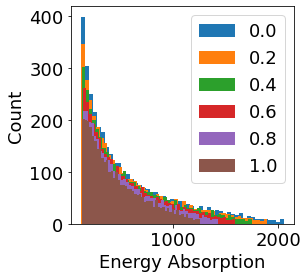

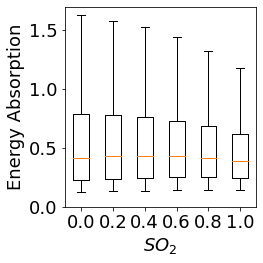

In [5]:
labels = parameters[variable].unique()
for s, label in zip(ms_results, labels):
    plt.hist(np.mean(s[volume_numbered == 4], axis=1), bins=50, label=label)
plt.xlabel("Energy Absorption")
plt.ylabel("Count")
plt.legend()
plt.show()
plt.boxplot([np.mean(s[volume_numbered == 4]/1000, axis=1) for s in ms_results], showfliers=False, labels=labels)
plt.xlabel("$SO_2$")
plt.ylabel("Energy Absorption")
plt.ylim([0,None])
plt.tight_layout()
plt.savefig("../FiguresOutput/so2_energy_box.png")
plt.show()

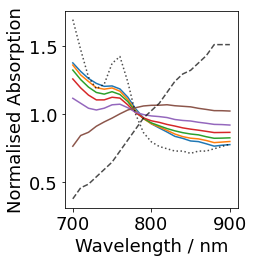

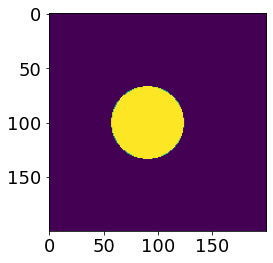

In [6]:
# Calculate the mean absorption spectra over the entire blood vessel over the independent variable.
n_thing = 65
mean_specs = [np.mean(result[volume_numbered == 4], axis=0) for result in ms_results]

wavelengths = parameters["Wavelength"].unique()
for spec, label in zip(mean_specs, labels):
    plt.plot(1e9*wavelengths, spec/np.mean(spec), label=label)

expected = blood_mu_a(wavelengths, 1)
plt.plot(wavelengths*1e9, expected/np.mean(expected), "--", c="k", alpha=0.7)

expected = blood_mu_a(wavelengths, 0)
plt.plot(wavelengths*1e9, expected/np.mean(expected), ":", c="k", alpha=0.7)
    
plt.xlabel("Wavelength / nm")
plt.ylabel("Normalised Absorption")
plt.tight_layout()
plt.savefig("../FiguresOutput/so2_abs_spec.png")
plt.show()

plt.imshow(volume_numbered== 4)
plt.show()

# Spectral Unmixing

In [7]:
# Load the basis spectra
hb = blood_mu_a(wavelengths, 0, water = False)
hbo2 = blood_mu_a(wavelengths, 1, water = False)
water = water_mu_a(wavelengths)
melanin = melanosome_mu_a(wavelengths)
test = np.ones_like(wavelengths)

# Calculate the forward and (pseudo)-inverse matrices
#spectra_matrix = np.array([hb, hbo2, water, melanin]).T
spectra_matrix = np.array([hb, hbo2, water, melanin]).T
inv_matrix = np.linalg.pinv(spectra_matrix)

# Apply the unmixing matrix
unmixed = [np.dot(result, inv_matrix.T) for result in ms_results]
so2 = [M[:, :, 1]/(M[:, :, 1] + M[:, :, 0]) for M in unmixed]
THb = [M[:, :, 1]+M[:, :, 0] for M in unmixed]

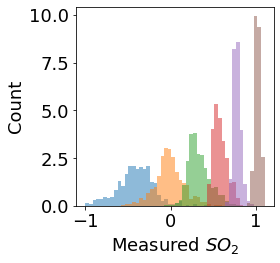

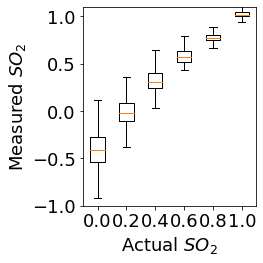

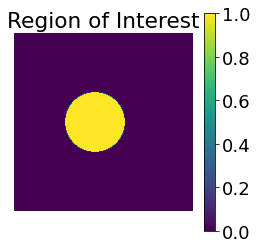

In [12]:
total = THb[5]

# Choose a region of interest in which 
ROI = (volume_numbered == 4) 

for s, label, thb in zip(so2, labels, THb):
    plt.hist(s[ROI*(thb>0.4)], bins=50, range=(-1, 1.1),
             label=label, density=True, alpha=0.5)
plt.xlabel("Measured $SO_2$")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("../FiguresOutput/so2_so2_hist.png")
plt.show()


plt.boxplot([s[ROI*(t>0.4)] for s,t in zip(so2,THb)],labels=labels, showfliers=False)
plt.xlabel("Actual $SO_2$")
plt.ylabel("Measured $SO_2$")
plt.ylim(-1,1.1)
plt.tight_layout()
plt.savefig("../FiguresOutput/so2_so2_box.png")
plt.show()


plt.imshow(ROI.astype('int8'))
plt.title("Region of Interest")
plt.colorbar()
plt.axis("off")
plt.show()

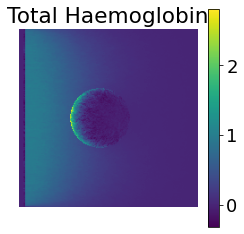

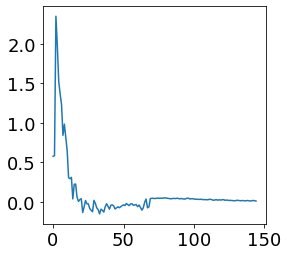

In [9]:
plt.imshow(THb[0])
plt.colorbar()
plt.axis("off")
plt.title("Total Haemoglobin")
plt.show()
plt.plot(THb[0][100, 55:])
plt.show()

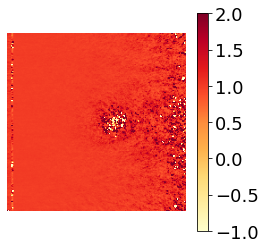

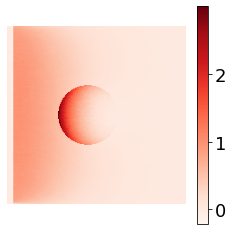

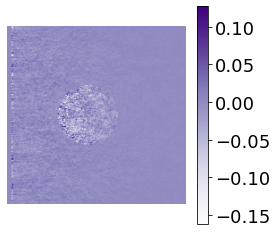

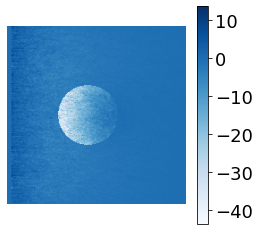

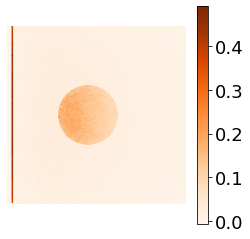

In [10]:
n=-1
# SO2
plt.imshow(so2[n], cmap="YlOrRd", clim=(-1,2))
plt.colorbar()
plt.axis("off")
plt.show()
# HbO2
plt.imshow(unmixed[n][:, :, 1], cmap="Reds")
plt.colorbar()
plt.axis("off")
plt.show()
# Hb
plt.imshow(unmixed[n][:, :, 0], cmap="Purples")
plt.colorbar()
plt.axis("off")
plt.show()
# Water
plt.imshow(unmixed[n][:, :, 2], cmap="Blues")
plt.colorbar()
plt.axis("off")
plt.show()
# Melanin
plt.imshow(unmixed[n][:, :, 3], cmap="Oranges")
plt.colorbar()
plt.axis("off")
plt.show()